Anushna Prakash  
DATA 598 - Deep Learning  
January 28 2022  
# <center> Homework 3 </center>  
## Part I: The Effect of BatchNorm on a ConvNet  

First, download and preprocess the data.

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


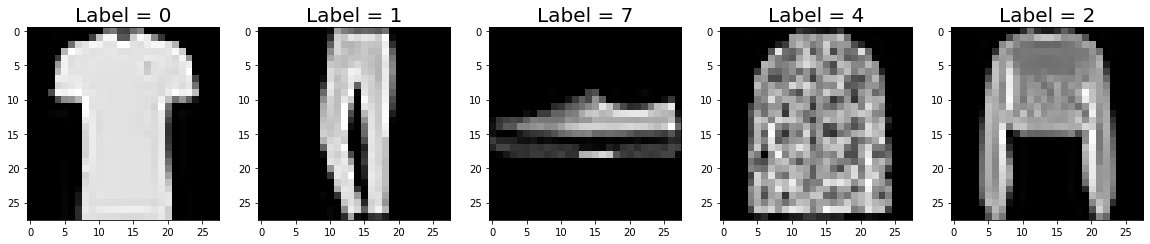

In [1]:
import torch
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import copy

# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

Create a Convolutional Neural Net with two convolutional layers:  
Input $(1, 28, 28) \rightarrow$ Convolution with $k=5$, `filters=16`, `padding=2` $\rightarrow$ ReLU $\rightarrow$ MaxPool with $k=2 \rightarrow$ Convolution with $k=5$, `filters=32`, `padding=2` $\rightarrow$ ReLU $\rightarrow$ MaxPool with $k=2 \rightarrow$ Linear output = 10

### Step 1: Figure out size `S` to flatten to  
This is for the `torch.nn.Linear` final step.  

In [2]:
image_size = 28
# 1 batch, 1 channel, 228x228 image
dummy = torch.randn(1, 1, image_size, image_size)

# Run dummy thru input layers
conv1 = torch.nn.Conv2d(
    in_channels=1, out_channels=16, kernel_size=5,
    padding=2, stride=1
)
out = conv1(dummy)
# 1 batch, 16 channels, image size, image size
print(out.shape)
relu = torch.nn.ReLU()
out = relu(out)
# 1 batch, 16 channels, image size, image size
print(out.shape)
pool = torch.nn.MaxPool2d(2)
out = pool(out)
# 1 batch, 16 channels, image size / kernel input size, image size / kernel input size
print(out.shape)

# Run thru second part
# Run dummy thru input layers
# Now has 16 input channels
conv2 = torch.nn.Conv2d(
    in_channels=16, out_channels=32, kernel_size=5,
    padding=2, stride=1
)
out = conv2(out)
# 1 batch, 32 channels, image size, image size
print(out.shape)
relu = torch.nn.ReLU()
out = relu(out)
# 1 batch, 32 channels, image size, image size
print(out.shape)
pool = torch.nn.MaxPool2d(2)
out = pool(out)
# 1 batch, 32 channels, image size / kernel input size, image size / kernel input size
print(out.shape)

# Now convert final out shape into 1 x 10

torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 14, 14])
torch.Size([1, 32, 14, 14])
torch.Size([1, 32, 14, 14])
torch.Size([1, 32, 7, 7])


### Step 2: Create `ConvNet` and `BatchNormConvNet`

In [3]:
class ConvNet(torch.nn.Module):
    """
    Defines a convolution neural net with 2 convolution layers
    Does not employ batch norming
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        # Final layer output is batch x channels x imagesize / 4 x imagesize / 4
        self.fully_connected_layer = torch.nn.Linear(7*7*32, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28) # Resize, needs channel
        out = self.conv_ensemble_1(x) # Run thru layer 1
        out = self.conv_ensemble_2(out) # Run thru layer 2
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

Create a Convolutional Neural Net that is the same as above, but has batch norm applied after each `MaxPool2d` layer.

In [4]:
class BatchNormConvNet(torch.nn.Module):
    """
    Defines a convolution neural net with 2 convolution layers
    Employ batch norming
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(num_features=16))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(num_features=32))
        self.fully_connected_layer = torch.nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28) # Resize, needs channel
        out = self.conv_ensemble_1(x) # Run thru layer 1
        out = self.conv_ensemble_2(out) # Run thru layer 2
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

In [5]:
# Test
model = ConvNet(num_classes=10)
model2 = BatchNormConvNet(num_classes=10)

out = model(dummy)
dummy = torch.randn(32, 1, image_size, image_size)
out = model2(dummy)

In [6]:
out.shape

torch.Size([32, 10])

### Step 3: Edit `compute_objectives` and `minibatch_sgd_one_pass`, etc.  
Edit prior functions to switch on/off training and eval modes

In [7]:
from torch.nn.functional import cross_entropy

def compute_objective(net, X, y):
    """ 
    Compute the multinomial logistic loss. 
    net is a module
    X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = net(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(net, X, y):
    """ 
    Compute the classification accuracy
    based on majority vote from augmented images.
    X of shape (n, d) and y of shape (n,)
    """
    training_flag = net.training # Is model in training mode?
    net.eval()
    score = net(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    
    # Switch back to train when needed
    if training_flag:
        net.train()

    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(net, X_train, y_train, X_test, y_test, verbose=False):
    """
    Compute loss & accuracy for train & test
    Returns values in tuple in the order:
    Train Loss, Train Accuracy, Test Loss, Test Accuracy
    """
    training_flag = net.training
    net.eval() # Switch to eval
    train_loss = compute_objective(net, X_train, y_train)
    test_loss = compute_objective(net, X_test, y_test)
    
    train_accuracy = compute_accuracy(net, X_train, y_train)
    test_accuracy = compute_accuracy(net, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    
    # Switch back to training mode if needed
    if training_flag:
        net.train()

    return (train_loss, train_accuracy, test_loss, test_accuracy)

def minibatch_sgd_one_pass(net, X, y, learning_rate, batch_size, verbose=False):
    """
    Performs one pass of stochastic gradient descent.
    """
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(num_examples, size=(batch_size,))
        X_transformed = X[idxs]
        
        # Be in training mode
        net.train()
        objective = compute_objective(net, X_transformed, y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        gradients = torch.autograd.grad(outputs=objective, inputs=net.parameters())
        # perform SGD update inplace
        with torch.no_grad():
            for (w, g) in zip(net.parameters(), gradients):
                w -= learning_rate * g
    return net

### Step 4: Compute local smoothness  

$$ \hat{L}(w;u)=\frac{||\nabla f(w+u) - \nabla f(w)||_2}{||u||_2}$$  
where  
$$ u = -\eta \frac{1}{B} \sum_{b=1}^{B} \nabla_w \ell(y_{i_b},\phi(x_{i_b};w))$$

In [10]:
def compute_local_smoothness(net, X, y, learning_rate, batch_size):
    """
    Compute local smoothness
    """
    net.train()
    # Get batch
    num_examples = X.shape[0]
    idxs = np.random.choice(num_examples, size=(batch_size,))
    
    X_batch = X[idxs]
    y_batch = y[idxs]
    
    # Compute u
    obj = compute_objective(net, X_batch, y_batch)
    grad_u = torch.autograd.grad(outputs=obj, inputs=net.parameters())
    curr_u = [-learning_rate * g for g in grad_u]
    
    # Compute f(w)
    obj = compute_objective(net, X, y)
    grad_f_w = torch.autograd.grad(outputs=obj, inputs=net.parameters())
    net_copy = copy.deepcopy(net)
    
    # Update copy inplace
    with torch.no_grad():
        for (w, u) in zip(net_copy.parameters(), curr_u):
            w += u
    
    # Get grad_f_w_u
    new_obj = compute_objective(net_copy, X, y)
    grad_f_w_u = torch.autograd.grad(outputs=new_obj, inputs=net_copy.parameters())
    
    # Compute loss
    numerator = 0
    for (w_u, w) in zip(grad_f_w_u, grad_f_w):
        numerator += torch.linalg.norm(w_u - w)
    numerator = torch.sqrt(numerator)
    denominator = 0
    for u in curr_u:
        denominator += torch.linalg.norm(u)
    denominator = torch.sqrt(denominator)
    
    local_smoothness = numerator / denominator
    print('Local smoothness: ', str(local_smoothness))
    
    return local_smoothness

### Step 5: Train models

In [11]:
# Get logs & smoothness
basic_net = ConvNet()
batch_net = BatchNormConvNet()

# Parameters
LEARNING_RATE = 0.04
BATCH_SIZE = 32
MAX_PASSES = 10

logs = []
smoothness = []
for net in [basic_net, batch_net]:
    log = []
    smooth = []
    for i in range(MAX_PASSES):
        net = minibatch_sgd_one_pass(net, X_train, y_train, LEARNING_RATE, BATCH_SIZE)
        log.append(
            compute_logs(net, X_train, y_train, X_test, y_test, verbose=True)
        )
        smooth.append(
            compute_local_smoothness(net, X_train, y_train, LEARNING_RATE, BATCH_SIZE)
        )
    logs.append(np.asarray(log))
    smoothness.append(np.asarray(smooth))

Train Loss = 0.554, Train Accuracy = 0.804, Test Loss = 0.606, Test Accuracy = 0.781
Local smoothness:  tensor(4.0366)
Train Loss = 0.444, Train Accuracy = 0.841, Test Loss = 0.540, Test Accuracy = 0.816
Local smoothness:  tensor(3.8650)
Train Loss = 0.421, Train Accuracy = 0.847, Test Loss = 0.530, Test Accuracy = 0.810
Local smoothness:  tensor(3.6745)
Train Loss = 0.355, Train Accuracy = 0.872, Test Loss = 0.490, Test Accuracy = 0.833
Local smoothness:  tensor(2.9702)
Train Loss = 0.337, Train Accuracy = 0.880, Test Loss = 0.482, Test Accuracy = 0.839
Local smoothness:  tensor(3.5056)
Train Loss = 0.287, Train Accuracy = 0.896, Test Loss = 0.466, Test Accuracy = 0.852
Local smoothness:  tensor(2.8064)
Train Loss = 0.284, Train Accuracy = 0.900, Test Loss = 0.494, Test Accuracy = 0.848
Local smoothness:  tensor(2.0642)
Train Loss = 0.292, Train Accuracy = 0.892, Test Loss = 0.490, Test Accuracy = 0.833
Local smoothness:  tensor(2.9158)
Train Loss = 0.233, Train Accuracy = 0.919, Test

### Deliverable: 3 Plots

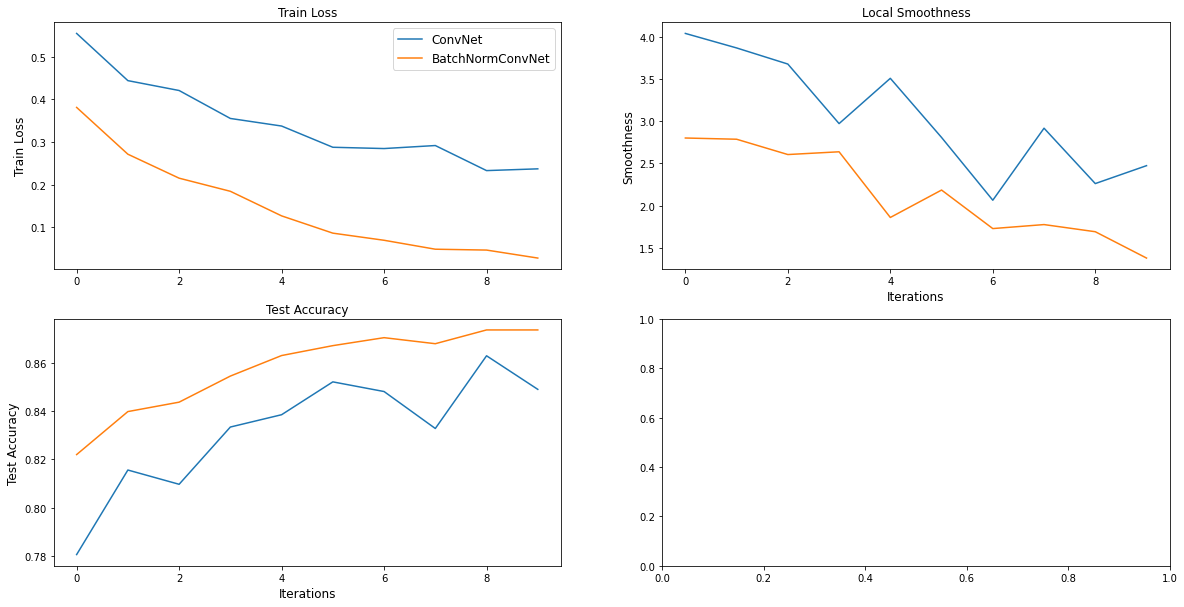

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

models = ['ConvNet', 'BatchNormConvNet']
for i, m in enumerate(models):
    # Plot train loss and test accuracy
    ax[0][0].plot(logs[i][:,0], label=m)
    ax[1][0].plot(logs[i][:,-1], label=m)
    # Plot local smoothness
    ax[0][1].plot(smoothness[i], label=m)

ax[0][0].set_ylabel('Train Loss', fontsize=12)
ax[0][0].set_title('Train Loss', fontsize=12)
ax[1][0].set_xlabel('Iterations', fontsize=12)
ax[1][0].set_ylabel('Test Accuracy', fontsize=12)
ax[1][0].set_title('Test Accuracy', fontsize=12)
ax[0][1].set_xlabel('Iterations', fontsize=12)
ax[0][1].set_ylabel('Smoothness', fontsize=12)
ax[0][1].set_title('Local Smoothness', fontsize=12)
ax[0][0].legend(fontsize=12)

### Deliverable: Commentary on Plots  

It seems that local effective smoothness is much lower when using the `BatchNormConvNet` model, indicating that it is smoother. It also shows less volatility compared to the `ConvNet` without using batch norming, and its train loss and test accuracy improve more smoothly over the 10 iterations as well. This indicates that the model is able to more easily stochastically descend towards the minimum of the loss function. This is because the outputs from the layers of the model, when not normalized, can compound and become very very large, or very very small and lead to exploding or vanishing gradients. Normalizing controls that impact, and so the gradients at each location are less volatile, allowing us to take larger steps for gradient descent.